### $\S1$ . Dataset Overview

**Source:** https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus

**Context:**
The Annotated Corpus for Named Entity Recognition is extract from GMB([Groningen Meaning Bank](https://developer.ibm.com/exchanges/data/all/groningen-meaning-bank/)) corpus. The dataset contains only documents authored by Voice of America VOA, together with documents from the MASC dataset and the CIA World Factbook.

The datasets (`ner_dataset.csv` and `ner.csv`) represent tokenized corpora. They are tagged, annotated and built specifically to train a model to predict named entities such as name, location, etcetera. 

## Datasets: Annotated corpus for Named Entity Recognition 

Words in the sentence are tagged using the [IOB](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) format: 

- B - {CHUNK_TYPE} – for the word in the Beginning chunk
- I - {CHUNK_TYPE} – for words Inside the chunk
- O – Outside any chunk

The IOB tags are further classified into the following classes –

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

For the POS column, see [Penn Treebank Part-of-Speech tagset](https://www.sketchengine.eu/penn-treebank-tagset/) for the details. 

### $\S2$. Load the dataset

- Note: "One skipped line:  `line 281837: expected 25 fields, saw 34\n` in `ner.csv`"

#### Initial imports and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import spacy
import string
nlp = spacy.load('en_core_web_sm')

#### Checking versions

In [2]:
print(f"Pandas version:{pd.__version__}")

Pandas version:1.4.3


#### Loading and checking data sets

In [3]:
ner_df = pd.read_csv("./datasets/ner.csv", encoding='latin1', on_bad_lines="warn") 
dataset_df = pd.read_csv("./datasets/ner_dataset.csv", encoding='latin1') # utf-8 failed 

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
print(f"The shape of the table dataset_df is: {dataset_df.shape}")
dataset_df.head()

The shape of the table dataset_df is: (1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
print(f"The shape of the table ner_df is: {ner_df.shape}")
ner_df.head()

The shape of the table ner_df is: (1050795, 25)


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


### $\S3$. Initial inspection on two datasets: choose `ner_dataset.csv` over `ner.csv`

We inspected two datasets, and found that the dataset `ner.csv` is **missing sentences from `sentence_idx = 18617` to  `sentence_idx=31399`.**

To fill in the missing values, we need to re-derive them from `ner.csv`. Hence, it makes sense to simply discard `ner.csv` and do EDA and feature engineer on the more primitive and complete dataset `ner.csv`. 

For the details, see the code in this section below. 

In [6]:
ner_df.sample(10)

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
199718,199718,say,81,suspect,JJ,lowercase,suspected,CD,number,81,...,u.s.,NNP,abbreviation,U.S.,lowercase,military,9145.0,lowercase,says,O
96794,96794,ivori,coast,",",",",punct,",",NNP,capitalized,Coast,...,ethiopia,NNP,capitalized,Ethiopia,punct,",",4407.0,capitalized,Ivory,B-geo
247812,247812,centuries-old,arab-african,saharan,JJ,capitalized,Saharan,JJ,contains-hyphen,Arab-African,...,enslav,VBN,lowercase,enslaved,lowercase,along,11339.0,contains-hyphen,centuries-old,O
775433,773213,mohammad,was,kill,VBN,lowercase,killed,VBD,lowercase,was,...,hatem,NNP,capitalized,Hatem,capitalized,Rashid,35342.0,capitalized,Mohammad,I-per
876042,873822,from,iraq,'s,POS,other,'s,NNP,capitalized,Iraq,...,more,RBR,lowercase,more,lowercase,isolated,39924.0,lowercase,from,O
528199,246364,the,economi,such,JJ,lowercase,such,NN,lowercase,economy,...,area,NNS,lowercase,areas,lowercase,of,11281.0,lowercase,the,O
121976,121976,secur,situat,in,IN,lowercase,in,NN,lowercase,situation,...,iraq,NNP,capitalized,Iraq,other,'s,5559.0,lowercase,security,O
830864,828644,isra,from,attack,NNS,lowercase,attacks,IN,lowercase,from,...,to,TO,lowercase,to,lowercase,protect,37871.0,capitalized,Israelis,B-gpe
422269,140434,.,__end1__,__end2__,__END2__,wildcard,__END2__,__END1__,wildcard,__END1__,...,afghan,JJ,capitalized,Afghan,lowercase,border,6402.0,punct,.,O
114338,114338,integr,of,the,DT,lowercase,the,IN,lowercase,of,...,evolv,VBG,lowercase,evolving,lowercase,economic,5206.0,lowercase,integration,O


#### Exploring missing values

In [7]:
ner_df.isnull().sum()

Unnamed: 0         0
lemma              0
next-lemma         0
next-next-lemma    0
next-next-pos      0
next-next-shape    0
next-next-word     0
next-pos           0
next-shape         1
next-word          1
pos                1
prev-iob           1
prev-lemma         1
prev-pos           1
prev-prev-iob      1
prev-prev-lemma    1
prev-prev-pos      1
prev-prev-shape    1
prev-prev-word     1
prev-shape         1
prev-word          1
sentence_idx       1
shape              1
word               1
tag                1
dtype: int64

There are some missing values in `ner.csv`

Selecting the row with missing values: 

In [8]:
ner_df[ner_df.isnull().any(axis=1)]

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
689433,407598,domin,countri,.,.,punct,.nister,O,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing out rows around the row with missing values:  

In [9]:
row_w_nan = 689433
ner_df.iloc[row_w_nan-22: row_w_nan+5]

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
689411,407576,iran,'s,state-run,JJ,contains-hyphen,state-run,POS,other,'s,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,18616.0,capitalized,Iran,B-geo
689412,407577,'s,state-run,televis,NN,lowercase,television,JJ,contains-hyphen,state-run,...,__start1__,__START1__,wildcard,__START1__,capitalized,Iran,18616.0,other,'s,O
689413,407578,state-run,televis,saturday,NNP,capitalized,Saturday,NN,lowercase,television,...,iran,NNP,capitalized,Iran,other,'s,18616.0,contains-hyphen,state-run,O
689414,407579,televis,saturday,quot,VBD,lowercase,quoted,NNP,capitalized,Saturday,...,'s,POS,other,'s,contains-hyphen,state-run,18616.0,lowercase,television,O
689415,407580,saturday,quot,khamenei,NNP,capitalized,Khamenei,VBD,lowercase,quoted,...,state-run,JJ,contains-hyphen,state-run,lowercase,television,18616.0,capitalized,Saturday,B-tim
689416,407581,quot,khamenei,as,IN,lowercase,as,NNP,capitalized,Khamenei,...,televis,NN,lowercase,television,capitalized,Saturday,18616.0,lowercase,quoted,O
689417,407582,khamenei,as,say,VBG,lowercase,saying,IN,lowercase,as,...,saturday,NNP,capitalized,Saturday,lowercase,quoted,18616.0,capitalized,Khamenei,B-per
689418,407583,as,say,nation,NNS,lowercase,nations,VBG,lowercase,saying,...,quot,VBD,lowercase,quoted,capitalized,Khamenei,18616.0,lowercase,as,O
689419,407584,say,nation,must,MD,lowercase,must,NNS,lowercase,nations,...,khamenei,NNP,capitalized,Khamenei,lowercase,as,18616.0,lowercase,saying,O
689420,407585,nation,must,have,VB,lowercase,have,MD,lowercase,must,...,as,IN,lowercase,as,lowercase,saying,18616.0,lowercase,nations,O


It seems like the last row of sentence 18616. So we want to look at sentence 18616 in the other dataset `ner_dataset.csv`

In [10]:
dataset_df.loc[dataset_df["Sentence #"]=="Sentence: 18616"]

,Sentence #,Word,POS,Tag
407576,Sentence: 18616,Iran,NNP,B-geo


In [11]:
dataset_df.iloc[407576: 407610]

,Sentence #,Word,POS,Tag
407576,Sentence: 18616,Iran,NNP,B-geo
407577,NaN,'s,POS,O
407578,NaN,state-run,JJ,O
407579,NaN,television,NN,O
407580,NaN,Saturday,NNP,B-tim
407581,NaN,quoted,VBD,O
407582,NaN,Khamenei,NNP,B-per
407583,NaN,as,IN,O
407584,NaN,saying,VBG,O
407585,NaN,nations,NNS,O


Here we realize that sentences from 18616 to 31399 are missing from `ner.csv`:

In [12]:
ner_df.loc[ner_df["sentence_idx"] == 200000]

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag


### $\S 4$ EDA on `ner_dataset.csv`

#### $\S 4.0$ Basic information

In [13]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [14]:
dataset_df.describe()  ## POS = NN:  noun, singular or mass 

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


In [15]:
dataset_df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


#### $\S 4.1$ Number of words in each Tag and POS

**Tags** 

In [16]:
dataset_df["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

Ploting the number of words that are tagged as the beginning of each type: "B-geo", "B-tim", "B-org", "B-per", "B-gpe", "B-art","B-eve", "B-nat"  

<AxesSubplot:>

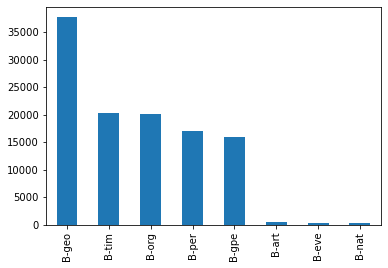

In [17]:
dataset_df[dataset_df["Tag"].isin(["B-geo", "B-tim", "B-org", "B-per", "B-gpe", "B-art","B-eve", "B-nat"])]["Tag"].value_counts().plot(kind="bar")

Looking at some of the tags:

In [18]:
dataset_df_gpe = dataset_df[dataset_df["Tag"] == "B-gpe"]

In [19]:
dataset_df_gpe.head()

,Sentence #,Word,POS,Tag
18,NaN,British,JJ,B-gpe
102,NaN,English,JJ,B-gpe
113,NaN,Britain,NNP,B-gpe
126,NaN,British,JJ,B-gpe
173,NaN,Iran,NNP,B-gpe


In [20]:
dataset_df_art = dataset_df[dataset_df["Tag"] == "B-art"]

In [21]:
dataset_df_art.head()

,Sentence #,Word,POS,Tag
263,NaN,Nuclear,NNP,B-art
3769,NaN,Saltillo,NNP,B-art
3810,NaN,Pentastar,NNP,B-art
3814,NaN,Chrysler,NNP,B-art
3816,NaN,Dodge,NNP,B-art


**POS**

In [22]:
dataset_df["POS"].value_counts()

NN      145807
NNP     131426
IN      120996
DT       98454
JJ       78412
NNS      75840
.        47831
VBD      39379
,        32757
VBN      32328
VBZ      24960
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11257
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: POS, dtype: int64

<AxesSubplot:>

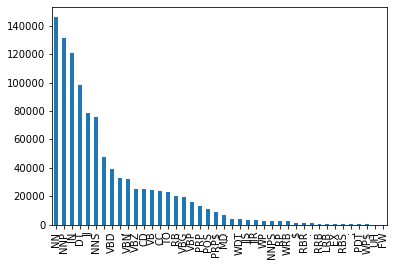

In [23]:
dataset_df["POS"].value_counts().plot(kind="bar")

#### $\S4.2$ Analysis on sentences 

**Total number of sentences: 47959**

In [24]:
dataset_df_sentences = dataset_df[dataset_df["Sentence #"].notnull()]

In [25]:
total_num_sentences = dataset_df_sentences.shape[0] 

In [26]:
print(total_num_sentences)

47959


**Analysis on the length of the sentences**

In [27]:
dataset_df_sentences

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
24,Sentence: 2,Families,NNS,O
54,Sentence: 3,They,PRP,O
68,Sentence: 4,Police,NNS,O
83,Sentence: 5,The,DT,O
...,...,...,...,...
1048501,Sentence: 47955,Indian,JJ,B-gpe
1048521,Sentence: 47956,Indian,JJ,B-gpe
1048545,Sentence: 47957,Two,CD,O
1048556,Sentence: 47958,They,PRP,O


In [28]:
sentences_len = []
df_sentences_idx = dataset_df_sentences.index
for idx in range(total_num_sentences - 1):
    sentences_len.append(df_sentences_idx[idx+1] - df_sentences_idx[idx])
# last sentence 
sentences_len.append(dataset_df.shape[0] - df_sentences_idx[-1] + 1)

In [29]:
df_sentences_len = pd.DataFrame(sentences_len, columns=["Sentence Length"])
df_sentences_len["Sentence#"] = [i for i in range(1, total_num_sentences+1)]

In [30]:
df_sentences_len

,Sentence Length,Sentence#
0,24,1
1,30,2
2,14,3
3,15,4
4,25,5
...,...,...
47954,20,47955
47955,24,47956
47956,11,47957
47957,11,47958


/Users/cody/anaconda3/envs/mle-course/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sentence Length', ylabel='Density'>

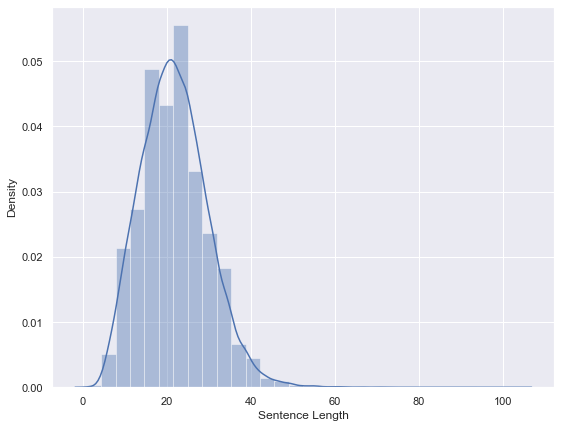

In [31]:
sns.set(rc={'figure.figsize':(9, 7)})
sns.distplot(df_sentences_len["Sentence Length"], bins=30)

<AxesSubplot:>

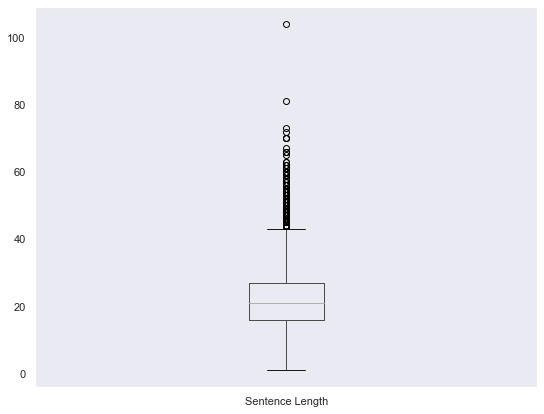

In [32]:
df_sentences_len.boxplot("Sentence Length", grid=False)

#### $\S4.3$ Analysis on words

**Analysis on the length of words**

In [33]:
lengths = []

for index, word in dataset_df.Word.iteritems():
    lengths.append(len(word))

In [34]:
print(sum(lengths) / len(lengths))

4.773359082564433


In [35]:
print(dataset_df.Word.iteritems())

/Users/cody/anaconda3/envs/mle-course/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

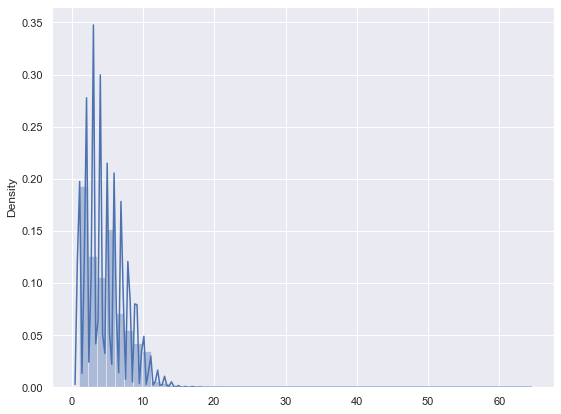

In [36]:
sns.distplot(lengths)

**Analysis on the capital and non-capital words**

In [37]:
capitals = {'capital': 0, 'non-capital': 0}

for index, word in dataset_df.Word.iteritems():
    if word[0].isupper():
        capitals['capital'] += 1
    else:
        capitals['non-capital'] += 1

<AxesSubplot:>

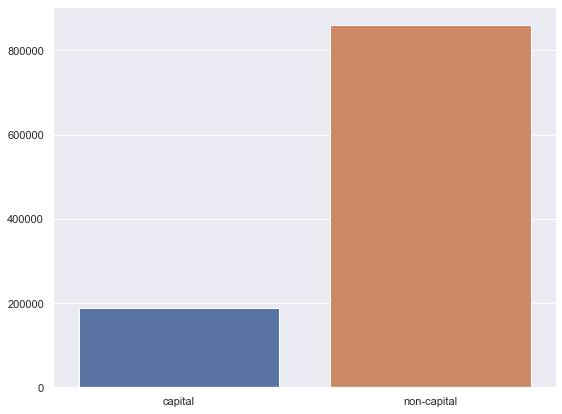

In [38]:
keys = list(capitals.keys())
vals = [float(capitals[k]) for k in keys]
sns.barplot(x=keys, y=vals)

**Analysis on stop words**

In [39]:
stop_words = {'stop-words': 0, 'non-stop-words': 0}

for index, word in dataset_df.Word.iteritems():
    if nlp.vocab[word].is_stop:
        stop_words['stop-words'] += 1
    else:
        stop_words['non-stop-words'] += 1

print(stop_words)

{'stop-words': 401041, 'non-stop-words': 647534}


<AxesSubplot:>

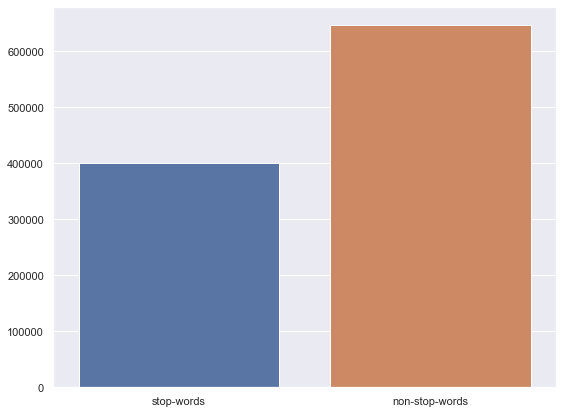

In [40]:
keys = list(stop_words.keys())
vals = [float(stop_words[k]) for k in keys]
sns.barplot(x=keys, y=vals)

#### $\S4.4$ Analysis on punctuation

**Analysis on punctuation**

In [41]:
punc = {'punctuation': 0, 'non-punctuation': 0}

for index, word in dataset_df.Word.iteritems():
    if word in string.punctuation:
        punc['punctuation'] += 1
    else:
        punc['non-punctuation'] += 1

<AxesSubplot:>

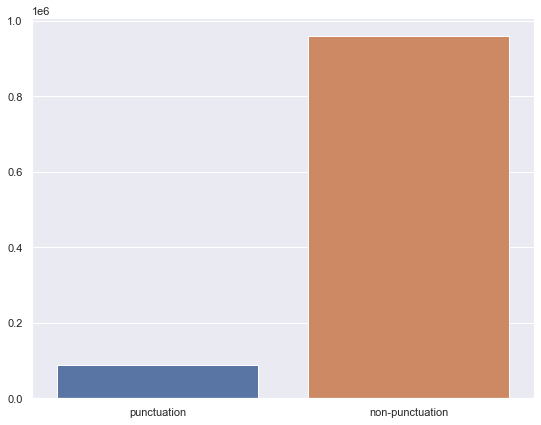

In [42]:
keys = list(punc.keys())
vals = [float(punc[k]) for k in keys]
sns.barplot(x=keys, y=vals)

### $\S5$. Correlation Checks: 

#### $\S5.0$ Creating DataFrame for new features

In [43]:
extended_df = dataset_df.copy()
extended_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


#### $\S5.1$ Adding features from EDA, and target variable

In [44]:
# Adding word length feature
extended_df['WordLength'] = extended_df.Word.str.len()

# Adding capital feature
extended_df['tmp'] = extended_df.Word.str[0]
extended_df['Capital'] = extended_df.tmp.str.isupper()
extended_df.drop(columns=['tmp'], inplace=True)

# Adding punctuation feature
extended_df['Non-Punctuation'] = extended_df.Word.str.isalnum()

# Adding stop-word feature
stop_list = []
for index, word in extended_df.Word.iteritems():
    if nlp.vocab[word].is_stop:
        stop_list.append(True)
    else:
        stop_list.append(False)
extended_df['StopWord'] = pd.Series(stop_list)

# Adding NER target
tag = extended_df.Tag.str[0]
extended_df['IsNER'] = np.where(tag == 'B', 1, 0)

In [45]:
extended_df.head(50)

,Sentence #,Word,POS,Tag,WordLength,Capital,Non-Punctuation,StopWord,IsNER
0,Sentence: 1,Thousands,NNS,O,9,True,True,False,0
1,NaN,of,IN,O,2,False,True,True,0
2,NaN,demonstrators,NNS,O,13,False,True,False,0
3,NaN,have,VBP,O,4,False,True,True,0
4,NaN,marched,VBN,O,7,False,True,False,0
5,NaN,through,IN,O,7,False,True,True,0
6,NaN,London,NNP,B-geo,6,True,True,False,1
7,NaN,to,TO,O,2,False,True,True,0
8,NaN,protest,VB,O,7,False,True,False,0
9,NaN,the,DT,O,3,False,True,True,0


#### $\S5.2$ Checking correlations with target variable

<AxesSubplot:>

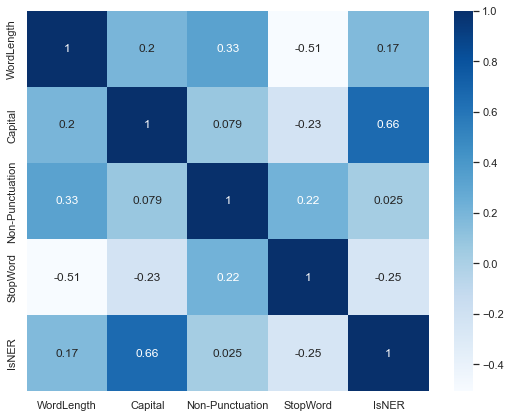

In [46]:
corr = extended_df.corr()
sns.heatmap(corr, annot=True, cmap='Blues')

### $\S6$. Questions: 

1. How certain are we of the labels that came with the dataset?
 - We should do additional analysis to determine if they look correct
2. What method (if any) do we want to use to re-derive the extended dataset?
3. What features jump out as obvious features to aid in prediction?
 - Word length?
 - Stop words?
 - Capitalization?